# Mantisshrimp

- Most kernels here show the Power of Pytorch Faster RCNN and Pytorch.
- Let me show you the power of Mantisshrimp. A library meant for object-detection.
- Built on Top of Pytorch Lightning and Pytorch, it provides flexible model implementations.
- Facilitates both researchers as well as DL engineers.
- Do check us here https://github.com/lgvaz/mantisshrimp

# Install
- Simple have Pytorch and get this from GitHub (release on PyPi to be soon)

```
pip install -r requirements.txt
pip install git+git://github.com/lgvaz/mantisshrimp.git
```

In [1]:
!pip install -q 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [2]:
! pip -q install git+git://github.com/lgvaz/mantisshrimp.git

# Let's get our hands dirty with it


Imports

Mantisshrimp is built in such a way that is safe to use wildcard imports, .e.g. from mantisshrimp import *.

from mantisshrimp.imports import * will import commonly used packages like np and plt.

from mantisshrimp import * will import all mantis modules needed for development.


In [3]:
from mantisshrimp.imports import *
from mantisshrimp import *
import pandas as pd
import albumentations as A

# Lets get the Data
-  The first step is to understand the data. In this task we were given a .csv file with annotations, let's take a look at that.

- Note:

- Replace source with your own path for the dataset directory.


## Parser

The first step is to understand the data. In this task we were given a .csv file with annotations, let's take a look at that.


In [4]:
source = Path('../input/global-wheat-detection/')
df = pd.read_csv(source / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


At first glance, we can make the following assumptions:

-    Multiple rows with the same object_id, width, height
-    A different bbox for each row
-    source doesn't seem relevant right now

- Once we know what our data provides we can create our custom Parser.

- When creating a Parser we inherit from smaller building blocks that provides the functionallity we want:

-    DefaultImageInfoParser: Will parse standard fields for image information, e.g. filepath, height, width
-    FasterRCNNParser: Since we only need to predict bboxes we will use a FasterRCNN model, this will parse all the requirements for using such a model.

We can also specify exactly what fields we would like to parse, in fact, the parsers we are currently using are just helper classes that groups a collection of individual parsers.

We are going to see how to use individual parsers in a future tutorial.




Defining the __init__ is completely up to you, normally we have to pass our data (the df in our case) and the folder where our images are contained (source in our case).

We then override __iter__, telling our parser how to iterate over our data. In our case we call df.itertuples to iterate over all df rows.

__len__ is not obligatory but will help visualizing the progress when parsing.

And finally we override all the other methods, they all receive a single argument o, which is the object returned by __iter__.

Now we just need to decide how to split our data and Parser.parse!


In [5]:
class WheatParser(DefaultImageInfoParser, FasterRCNNParser):
    def __init__(self, df, source):
        self.df = df
        self.source = source
        self.imageid_map = IDMap()

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> int:
        return self.imageid_map[o.image_id]

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def height(self, o) -> int:
        return o.height

    def width(self, o) -> int:
        return o.width

    def label(self, o) -> List[int]:
        return [1]

    def bbox(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))]

## Mantisshrimp now simplifes the boiler plate for you :-)

- It creates a RandomSpitter which divides data into trainand test.
- Then we create the parser and simply parse the data

In [6]:
data_splitter = RandomSplitter([.8, .2])
parser = WheatParser(df, source / "train")
train_rs, valid_rs = parser.parse(data_splitter)

Let's take a look at one record.

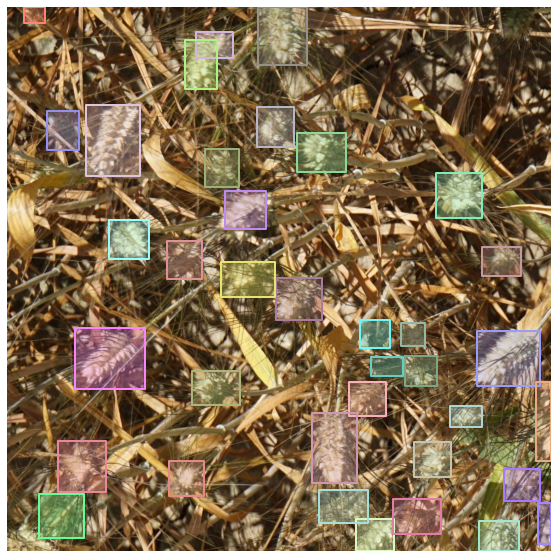

In [7]:
show_record(train_rs[0], label=False)

# Transforms

Mantisshrimp is agnostic to the transform library you want to use. We provide default support for albumentations but if you want to use another library you just need to inherit and override all abstract methods of Transform.

For simplicity, let's use a single transform on the train data and no transforms on the validation data.


In [55]:
train_tfm = AlbuTransform([A.Flip()])

# Datasets


- This is equivalent to PyTorch datasets that we use always.
- For creating a Dataset we just need need to pass the parsed records from the previous step and optionally a transform.

In [56]:
train_ds = Dataset(train_rs, train_tfm)
valid_ds = Dataset(valid_rs)


# Model


- It uses the torchvision implementation of Faster RCNN which most people are using here.
- Best part, we can try Faster RCNN with multiple Backbones, and its hardly any line of code.
- It allows flexible model implementation coz we don't want to limit the library

In [10]:
from mantisshrimp.models.mantis_rcnn import *

- It supports many resnet models with fpn on top of it.
- You can use pretrained imagenet Backbones as well.

- Is supports backbones "resnet18", "resnet34","resnet50", "resnet101", "resnet152", "resnext50_32x4d", "resnext101_32x8d", "wide_resnet50_2", "wide_resnet101_2", as resnets with fpn backbones.

In [11]:
resnet_101_backbone = MantisFasterRCNN.get_backbone_by_name("resnet101", fpn=True, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [12]:
resnet_152_backbone = MantisFasterRCNN.get_backbone_by_name("resnet152", fpn=True, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


- It supports backbones "resnet18", "resnet34", "resnet50","resnet101", "resnet152", "resnext101_32x8d", "mobilenet", "vgg11", "vgg13", "vgg16", "vgg19", without fpn networks

In [13]:
mobibenet_v2_backbone = MantisFasterRCNN.get_backbone_by_name("mobilenet", fpn=False, pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


- Now pytorch-lightning enters the picture.

- Everything from now is almost pure lightning, the only big difference is that instead of inheriting from LightningModule we inherit  from the specialized MantisFasterRCNN, this will automatically create the model architecture and load the backbones

- If you are not familiar with lightning, be sure to check their excellent documentation.

In [14]:
class WheatModel(MantisFasterRCNN):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 1e-3, momentum=0.9)
        return opt

In [15]:
model = WheatModel(n_class=2, backbone=resnet_101_backbone)

- It bacame so simple to create the model with resnet 152 backbone and fpn isn't it?
- You don't have these backbones should be connected with Faster RCNN, Mantisshrimp integrates them.
- Just inherit from the class, and add your optimizers as you would do in pytorch_lightning

 ## DataLoader

Another difference from lightning is that all mantis models have a `dataloader` method that returns a customized `DataLoader` for each model.

- This dataloader is just usual torch dataloader.

In [16]:
train_dl = model.dataloader(train_ds, shuffle=True, batch_size=8, num_workers=2)
valid_dl = model.dataloader(valid_ds, batch_size=8, num_workers=2)

In [58]:
test_dl = model.dataloader(test_ds, batch_size=2, num_workers=2)

# Train

- Again leverage the power of Pytorch Lightning.
- Train for multiple GPUs, withe the same trainer function that of lightning.
- Scale up your code easily

# Why Mantishrimp

In [17]:
trainer = Trainer(max_epochs=3, gpus=1)
trainer.fit(model, train_dl, valid_dl)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                                | Type                     | Params
-----------------------------------------------------------------------------
0   | backbone                            | BackboneWithFPN          | 45 M  
1   | backbone.body                       | IntermediateLayerGetter  | 42 M  
2   | backbone.body.conv1                 | Conv2d                   | 9 K   
3   | backbone.body.bn1                   | FrozenBatchNorm2d        | 0     
4   | backbone.body.relu                  | ReLU                     | 0     
5   | backbone.body.maxpool               | MaxPool2d                | 0     
6   | backbone.body.layer1                | Sequential               | 212 K 
7   | backbone.body.layer1.0              | Bottleneck               | 73 K  
8   | backbone.body.layer1.0.conv1        | Conv2d                   | 4 K   
9   | backbone.body.layer1

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider i

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


1

- You see the power and flexibility.
- Easily define the backbones and the models.
- Scale up easily with lightning.
- Ready for research and for competiions as well.
- We don't hide Pytorch Code, it is written in raw Pytorch so no black magic.
- Less Boilerplate.

- Support for more models coming Soon :-) 
- We have FB Detr finetuning as well.
- Mantisshrimp aims at end-end object detection.
- Do give us a * on github. https://github.com/lgvaz/mantisshrimp
- And please upovte the kernel If you like it.
- I will answer to comments regarding mantisshrimp as well.

# Making Predictions Work in Progress Stay tuned

Really usefel code taken from https://www.kaggle.com/aryaprince/getting-started-with-object-detection-with-pytorch

Note this is just a baseline. You will definetely get better LB, you can use multiple GPUs with lightning.

Also try diffrent backbones, etc.

In [18]:
detection_threshold = 0.45

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [52]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        pred_strings.append(f'{s:.4f} {b[0]} {b[1]} {b[2] - b[0]} {b[3] - b[1]}')

    return " ".join(pred_strings)

In [69]:
detection_threshold = 0.5
results = []
device = 'cuda'
for images in os.listdir("../input/global-wheat-detection/test/"):
    image_path = os.path.join("../input/global-wheat-detection/test/", images)
    model.predict(ima)

    boxes = outputs[i]['boxes'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]
    image_id = image_ids[i]

    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)

test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()



TypeError: 'module' object is not callable